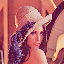

In [25]:
from io import BytesIO
from urllib.request import urlopen
from PIL import Image, ImageFile
import re
ImageFile.LOAD_TRUNCATED_IMAGES = True
import numpy as np

def fetch_image(image_path):
    """画像を読み込むメソッド
    """
    if re.match("""^(http|https):""", image_path):
        image_bytes = urlopen(image_path).read()
        img = Image.open(BytesIO(image_bytes))
    else:
        img = Image.open(image_path)
    return img.convert('RGB').resize((64, 64))

img = 'https://upload.wikimedia.org/wikipedia/en/2/24/Lenna.png'
fetch_image(img)

In [26]:
from keras.preprocessing.image import img_to_array

def img2array(img):
    """画像を数値に変換するメソッド
    """
    return img_to_array(fetch_image(img)).reshape(1, 64, 64, 3)

img2array(img).shape

(1, 64, 64, 3)

In [6]:
"""性別・年齢推定モデル
"""

import logging
import sys
import numpy as np
from keras.models import Model
from keras.layers import Input, Activation, add, Dense, Flatten, Dropout, GlobalAveragePooling2D
from keras.layers.convolutional import Conv2D, AveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from keras import backend as K

sys.setrecursionlimit(2 ** 20)
np.random.seed(2 ** 10)

class WideResNet:
    def __init__(self, image_size, depth=16, k=8, include_top=True):
        self._depth = depth
        self._k = k
        self._include_top = include_top
        self._dropout_probability = 0
        self._weight_decay = 0.0005
        self._use_bias = False
        self._weight_init = "he_normal"

#         if K.image_dim_ordering() == "th":
#             logging.debug("image_dim_ordering = 'th'")
#             self._channel_axis = 1
#             self._input_shape = (3, image_size, image_size)
#         else:
        logging.debug("image_dim_ordering = 'tf'")
        self._channel_axis = -1
        self._input_shape = (image_size, image_size, 3)

    # Wide residual network http://arxiv.org/abs/1605.07146
    def _wide_basic(self, n_input_plane, n_output_plane, stride):
        def f(net):
            # format of conv_params:
            #               [ [kernel_size=("kernel width", "kernel height"),
            #               strides="(stride_vertical,stride_horizontal)",
            #               padding="same" or "valid"] ]
            # B(3,3): orignal <<basic>> block
            conv_params = [[3, 3, stride, "same"],
                           [3, 3, (1, 1), "same"]]

            n_bottleneck_plane = n_output_plane

            # Residual block
            for i, v in enumerate(conv_params):
                if i == 0:
                    if n_input_plane != n_output_plane:
                        net = BatchNormalization(axis=self._channel_axis)(net)
                        net = Activation("relu")(net)
                        convs = net
                    else:
                        convs = BatchNormalization(axis=self._channel_axis)(net)
                        convs = Activation("relu")(convs)

                    convs = Conv2D(n_bottleneck_plane, kernel_size=(v[0], v[1]),
                                          strides=v[2],
                                          padding=v[3],
                                          kernel_initializer=self._weight_init,
                                          kernel_regularizer=l2(self._weight_decay),
                                          use_bias=self._use_bias)(convs)
                else:
                    convs = BatchNormalization(axis=self._channel_axis)(convs)
                    convs = Activation("relu")(convs)
                    if self._dropout_probability > 0:
                        convs = Dropout(self._dropout_probability)(convs)
                    convs = Conv2D(n_bottleneck_plane, kernel_size=(v[0], v[1]),
                                          strides=v[2],
                                          padding=v[3],
                                          kernel_initializer=self._weight_init,
                                          kernel_regularizer=l2(self._weight_decay),
                                          use_bias=self._use_bias)(convs)

            # Shortcut Connection: identity function or 1x1 convolutional
            #  (depends on difference between input & output shape - this
            #   corresponds to whether we are using the first block in each
            #   group; see _layer() ).
            if n_input_plane != n_output_plane:
                shortcut = Conv2D(n_output_plane, kernel_size=(1, 1),
                                         strides=stride,
                                         padding="same",
                                         kernel_initializer=self._weight_init,
                                         kernel_regularizer=l2(self._weight_decay),
                                         use_bias=self._use_bias)(net)
            else:
                shortcut = net

            return add([convs, shortcut])

        return f


    # "Stacking Residual Units on the same stage"
    def _layer(self, block, n_input_plane, n_output_plane, count, stride):
        def f(net):
            net = block(n_input_plane, n_output_plane, stride)(net)
            for i in range(2, int(count + 1)):
                net = block(n_output_plane, n_output_plane, stride=(1, 1))(net)
            return net

        return f

#    def create_model(self):
    def __call__(self):
        logging.debug("Creating model...")

        assert ((self._depth - 4) % 6 == 0)
        n = (self._depth - 4) / 6

        inputs = Input(shape=self._input_shape)

        n_stages = [16, 16 * self._k, 32 * self._k, 64 * self._k]

        conv1 = Conv2D(filters=n_stages[0], kernel_size=(3, 3),
                              strides=(1, 1),
                              padding="same",
                              kernel_initializer=self._weight_init,
                              kernel_regularizer=l2(self._weight_decay),
                              use_bias=self._use_bias)(inputs)  # "One conv at the beginning (spatial size: 32x32)"

        # Add wide residual blocks
        block_fn = self._wide_basic
        conv2 = self._layer(block_fn, n_input_plane=n_stages[0], n_output_plane=n_stages[1], count=n, stride=(1, 1))(conv1)
        conv3 = self._layer(block_fn, n_input_plane=n_stages[1], n_output_plane=n_stages[2], count=n, stride=(2, 2))(conv2)
        conv4 = self._layer(block_fn, n_input_plane=n_stages[2], n_output_plane=n_stages[3], count=n, stride=(2, 2))(conv3)
        batch_norm = BatchNormalization(axis=self._channel_axis)(conv4)
        relu = Activation("relu")(batch_norm)
    
        # Classifier block
        pool = AveragePooling2D(pool_size=(8, 8), strides=(1, 1), padding="same")(relu)
        
        if self._include_top:
            flatten = Flatten()(pool)
            predictions_g = Dense(units=2, kernel_initializer=self._weight_init, use_bias=self._use_bias,
                                  kernel_regularizer=l2(self._weight_decay), activation="softmax")(flatten)
            predictions_a = Dense(units=101, kernel_initializer=self._weight_init, use_bias=self._use_bias,
                                  kernel_regularizer=l2(self._weight_decay), activation="softmax")(flatten)
            model = Model(inputs=inputs, outputs=[predictions_g, predictions_a], name='wideresnet')
        else:
            x = GlobalAveragePooling2D()(pool)
            model = Model(inputs=inputs, outputs=x, name='wideresnet')            
            
        return model

In [12]:
"""学習済の結果をダウンロード
"""

!wget https://storage.googleapis.com/age-gender-estimation/data/weights_theano.16-3.99.hdf5
!mkdir -p pretrained_models/
!mv weights_theano.16-3.99.hdf5 pretrained_models/

--2017-10-06 06:48:44--  https://storage.googleapis.com/age-gender-estimation/data/weights_theano.16-3.99.hdf5
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.25.240, 2404:6800:4004:81b::2010
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.25.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 195845896 (187M) [application/octet-stream]
Saving to: ‘weights_theano.16-3.99.hdf5.1’

weights_theano.16-3 100%[===================>] 186.77M  4.14MB/s    in 80s     

2017-10-06 06:50:05 (2.32 MB/s) - ‘weights_theano.16-3.99.hdf5.1’ saved [195845896/195845896]



In [13]:
"""学習済の結果を読込
"""

import os

depth = 16
k = 8
img_size = 64
weight_file = os.path.join("pretrained_models", "weights_theano.16-3.99.hdf5")
wideresnet = model = WideResNet(img_size, depth=depth, k=k, include_top=True)()
wideresnet.load_weights(weight_file)

In [15]:
"""画像を入力して男・女/年齢の確率を予測してみる
"""

# ここのimgの顔写真を自由に変えてみる。urlでもlocal pathでもOK
img = 'https://upload.wikimedia.org/wikipedia/en/2/24/Lenna.png'
gender_pred, age_pred = model.predict(img2array(img))
gender_pred, age_pred

(array([[ 0.13396807,  0.86603194]], dtype=float32),
 array([[  1.01856931e-04,   4.55108384e-04,   2.78330233e-04,
           1.01668847e-04,   2.70781282e-04,   7.51574757e-04,
           1.02516590e-03,   1.61686377e-03,   2.89982837e-03,
           5.32606011e-03,   4.88431519e-03,   5.52113121e-03,
           7.24118575e-03,   5.73772052e-03,   7.32840318e-03,
           1.00825103e-02,   7.39987567e-03,   7.75246322e-03,
           6.76578749e-03,   8.84245150e-03,   1.14781242e-02,
           1.84623413e-02,   4.76537161e-02,   1.90789476e-02,
           4.04326841e-02,   2.66948547e-02,   5.29647544e-02,
           5.00592403e-02,   3.35420966e-02,   4.48545963e-02,
           4.79522943e-02,   2.35338919e-02,   3.70763540e-02,
           6.08783998e-02,   2.90236771e-02,   2.55871564e-02,
           3.98370102e-02,   2.95811892e-02,   2.74103973e-02,
           2.95094084e-02,   8.63913540e-03,   1.18542127e-02,
           1.77666023e-02,   9.15532187e-03,   1.16855027e-02,
  

推定： 33歳、男 [86.60319447517395%]


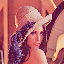

In [109]:
"""予測値をわかりやすいように変換する
"""

def _estimate(g_pred, a_pred):
    maybe_gender = np.argmax(g_pred)
    maybe_age = np.argmax(a_pred)
    if maybe_gender == 0:
        gender = '女'
    elif maybe_gender == 1:
        gender = '男'
    else:
        gender = 'ひみつ'
    gender_ratio = g_pred.flatten()[maybe_gender]
    return '推定： {}歳、{} [{}%]'.format(maybe_age, gender, gender_ratio * 100)

def estimate_age_gender(img_path):
    gender_pred, age_pred = model.predict(img2array(img_path))
    print(_estimate(gender_pred, age_pred))
    return fetch_image(img_path)

estimate_age_gender(img)

推定： 33歳、男 [62.085747718811035%]


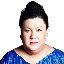

In [110]:
estimate_age_gender('http://boukenka.info/wp-content/uploads/2015/06/81cecb9c3736fa37df818c388a520c43.jpg')

推定： 33歳、男 [96.0084617137909%]


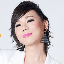

In [111]:
estimate_age_gender('https://scontent-nrt1-1.cdninstagram.com/t51.2885-15/sh0.08/e35/p640x640/18947677_1662155323805992_6270972588000804864_n.jpg')

推定： 33歳、男 [72.15290665626526%]


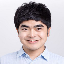

In [112]:
estimate_age_gender('http://tkarafuru.com/wp-content/uploads/2016/03/2016y03m06d_111456042.jpg')

推定： 36歳、男 [70.13391852378845%]


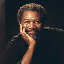

In [113]:
estimate_age_gender('https://pennylibertygbow.files.wordpress.com/2012/02/morgan.jpg')

推定： 36歳、男 [85.29545068740845%]


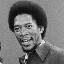

In [114]:
estimate_age_gender('http://livedoor.blogimg.jp/reer121/imgs/f/3/f3f43aca.jpg')

推定： 37歳、男 [71.97725772857666%]


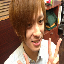

In [115]:
estimate_age_gender('http://vocalo-singer.com/wp-content/uploads/2015/05/%E5%BF%97%E9%BA%BB%E3%80%80%E9%A1%94.png')

推定： 39歳、男 [92.63883829116821%]


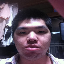

In [116]:
estimate_age_gender('https://iwiz-chie.c.yimg.jp/im_siggX9EwWFi_GUKx6ceE4.fk2w---x320-y320-exp5m-n1/d/iwiz-chie/que-13162859583')

推定： 36歳、男 [55.19440174102783%]


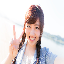

In [117]:
estimate_age_gender('https://www.pakutaso.com/shared/img/thumb/IMARI20160806343807.jpg')

# - fin -